In [329]:
from segpy.reader import create_reader
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow as tf

In [330]:
tf.config.run_functions_eagerly(True)

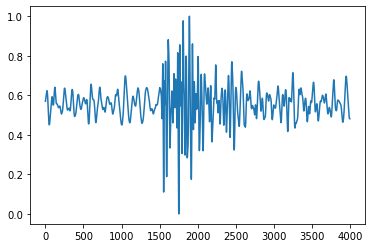

In [331]:
plt.plot(dataset[30])

In [332]:
dataset = []

directory = r'C:\Users\user\Desktop\2D\Correlated_Shot_Gathers'

for file_name in os.listdir(directory):
    
    if file_name != ".segpy":
        
        with open(directory + "\\" + file_name, 'rb') as segy_in_file:

            seg_y_dataset = create_reader(segy_in_file, endian='<')

            for i in seg_y_dataset.trace_indexes():
                dataset.append(seg_y_dataset.trace_samples(i)[:-1])
            
dataset = np.array(dataset)

In [333]:
max_dataset = np.max(dataset, axis = 1)
min_dataset = np.min(dataset, axis = 1)

In [334]:
dataset = (dataset - np.repeat(np.expand_dims(min_dataset,axis = 1), 4000, axis = 1))/(np.repeat(np.expand_dims(max_dataset,axis = 1), 4000, axis = 1) - np.repeat(np.expand_dims(min_dataset,axis = 1), 4000, axis = 1))

In [335]:
def get_metrics(x,x_pred):
    nmse = np.sum(np.square(x - x_pred))/np.sum(np.square(x))
    nrmse = np.sqrt(np.mean(np.square(x - x_pred)))/(np.amax(x) - np.amin(x))
    snr = -10*np.log10(nmse)
    return nmse, nrmse, snr

CR 5:1

In [355]:
model = keras.Sequential([
    #encoding
    keras.layers.Conv1D(16, 3, activation='elu', padding="same", input_shape=[4000,1]),
    keras.layers.Conv1D(32, 3, activation='elu', padding="same"),
    keras.layers.MaxPooling1D(pool_size=5),
    keras.layers.Conv1D(64, 3, activation='elu', padding="same"),
    keras.layers.Conv1D(128, 3, activation='elu', padding="same"),
    #encoded
    keras.layers.Conv1D(1, 3, activation='sigmoid', padding="same"),
    #decoding
    keras.layers.Conv1DTranspose(128, 3, activation='elu', padding="same"),
    keras.layers.Conv1DTranspose(64, 3, activation='elu', padding="same"),
    keras.layers.UpSampling1D(size=5),
    keras.layers.Conv1DTranspose(32, 3, activation='elu', padding="same"),
    keras.layers.Conv1DTranspose(16, 3, activation='elu', padding="same"),
    keras.layers.Conv1DTranspose(1, 3, padding="same"),
  ])

In [356]:
optimizer = tf.keras.optimizers.Adam(0.001)
model.compile(loss='mean_squared_error',optimizer=optimizer)

In [357]:
history = model.fit(np.expand_dims(dataset[:900],axis = 2),np.expand_dims(dataset[:900],axis = 2),batch_size = 16,epochs = 30)

Epoch 1/30
57/57 [==============================] - 16s 275ms/step - loss: 0.0388
Epoch 2/30
57/57 [==============================] - 16s 281ms/step - loss: 0.0139
Epoch 3/30
57/57 [==============================] - 17s 291ms/step - loss: 0.0043
Epoch 4/30
57/57 [==============================] - 17s 291ms/step - loss: 6.3267e-04
Epoch 5/30
57/57 [==============================] - 17s 296ms/step - loss: 5.4805e-04
Epoch 6/30
57/57 [==============================] - 17s 297ms/step - loss: 4.5711e-04
Epoch 7/30
57/57 [==============================] - 16s 289ms/step - loss: 3.7174e-04
Epoch 8/30
57/57 [==============================] - 17s 293ms/step - loss: 3.2189e-04
Epoch 9/30
57/57 [==============================] - 17s 296ms/step - loss: 3.2154e-04
Epoch 10/30
57/57 [==============================] - 17s 300ms/step - loss: 2.3920e-04
Epoch 11/30
57/57 [==============================] - 16s 280ms/step - loss: 2.5618e-04
Epoch 12/30
57/57 [==============================] - 16s 288ms/s

In [358]:
predicted = model.predict(np.expand_dims(dataset[:100],axis = 2))

In [359]:
np.array([get_metrics(dataset[i],predicted[i].flatten()) for i in range(100)]).mean(axis = 0)

array([1.47829002e-03, 1.10215949e-02, 3.39882343e+01])

Quantization

In [360]:
from keras.models import Model

encoder = Model(inputs=model.inputs, outputs=model.layers[-7].output)
decoder = Model(inputs=model.layers[-7].output, outputs=model.output)

In [361]:
def get_cr_and_metrics(dataset, encoder, decoder, quantization_level = 0.1):
    
    encoded_dataset = encoder.predict(np.expand_dims(dataset,axis = 2))
    
    total_length = encoded_dataset.shape[1] * int(np.log(1 / quantization_level) / np.log(2) + 1)
    
    quantized_encoded_dataset = (encoded_dataset // quantization_level)*quantization_level
    
    reconstructed_dataset = decoder.predict(quantized_encoded_dataset)
        
    return 4001*64/total_length, np.array([get_metrics(dataset[i],reconstructed_dataset[i].flatten()) for i in range(len(dataset))]).mean(axis = 0)

In [379]:
get_cr_and_metrics(dataset[900:1000], encoder, decoder, 0.005)

(40.01, array([1.69952930e-04, 6.66217692e-03, 3.78680591e+01]))

CR 30:1

In [380]:
model = keras.Sequential([
    #encoding
    keras.layers.Conv1D(8, 3, activation='elu', padding="same", input_shape=[3990,1]),
    keras.layers.MaxPooling1D(pool_size=3),
    keras.layers.Conv1D(16, 3, activation='elu', padding="same"),
    keras.layers.MaxPooling1D(pool_size=5),
    keras.layers.Conv1D(32, 3, activation='elu', padding="same"),
    keras.layers.MaxPooling1D(pool_size=2),
    keras.layers.Conv1D(64, 3, activation='elu', padding="same"),
    keras.layers.Conv1D(128, 3, activation='elu', padding="same"),
    #encoded
    keras.layers.Conv1D(1, 3, activation='sigmoid', padding="same"),
    #decoding
    keras.layers.Conv1DTranspose(128, 3, activation='elu', padding="same"),
    keras.layers.Conv1DTranspose(64, 3, activation='elu', padding="same"),
    keras.layers.UpSampling1D(size=2),
    keras.layers.Conv1DTranspose(32, 3, activation='elu', padding="same"),
    keras.layers.UpSampling1D(size=5),
    keras.layers.Conv1DTranspose(16, 3, activation='elu', padding="same"),
    keras.layers.UpSampling1D(size=3),
    keras.layers.Conv1DTranspose(8, 3, activation='elu', padding="same"),
    keras.layers.Conv1DTranspose(1, 3, padding="same"),
  ])

In [381]:
optimizer = tf.keras.optimizers.Adam(0.001)
model.compile(loss='mean_squared_error',optimizer=optimizer)

In [382]:
history = model.fit(np.expand_dims(dataset[:900,:3990],axis = 2),np.expand_dims(dataset[:900,:3990],axis = 2),batch_size = 16,epochs = 30)

Epoch 1/30
57/57 [==============================] - 9s 162ms/step - loss: 0.0272
Epoch 2/30
57/57 [==============================] - 9s 159ms/step - loss: 0.0155
Epoch 3/30
57/57 [==============================] - 9s 161ms/step - loss: 0.0137
Epoch 4/30
57/57 [==============================] - 9s 163ms/step - loss: 0.0071
Epoch 5/30
57/57 [==============================] - 10s 167ms/step - loss: 0.0055
Epoch 6/30
57/57 [==============================] - 9s 160ms/step - loss: 0.0053
Epoch 7/30
57/57 [==============================] - 9s 159ms/step - loss: 0.0052
Epoch 8/30
57/57 [==============================] - 9s 159ms/step - loss: 0.0051
Epoch 9/30
57/57 [==============================] - 9s 159ms/step - loss: 0.0051
Epoch 10/30
57/57 [==============================] - 9s 156ms/step - loss: 0.0051
Epoch 11/30
57/57 [==============================] - 9s 162ms/step - loss: 0.0050
Epoch 12/30
57/57 [==============================] - 9s 163ms/step - loss: 0.0050
Epoch 13/30
57/57 [=====

In [383]:
predicted = model.predict(np.expand_dims(dataset[:100,:3990],axis = 2))

In [384]:
np.array([get_metrics(dataset[i,:3990],predicted[i].flatten()) for i in range(100)]).mean(axis = 0)

array([ 0.01917838,  0.06405408, 19.02099607])

Quantization

In [385]:
from keras.models import Model

encoder = Model(inputs=model.inputs, outputs=model.layers[-10].output)
decoder = Model(inputs=model.layers[-10].output, outputs=model.output)

In [387]:
get_cr_and_metrics(dataset[900:1000,:3990], encoder, decoder, 0.1)

(481.3233082706767, array([ 0.05925832,  0.11822906, 12.9044286 ]))

In [388]:
get_cr_and_metrics(dataset[900:1000,:3990], encoder, decoder, 0.05)

(385.05864661654135, array([ 0.02404568,  0.07705442, 16.56134543]))

In [389]:
get_cr_and_metrics(dataset[900:1000,:3990], encoder, decoder, 0.01)

(275.0418904403867, array([1.35288386e-02, 5.71208357e-02, 1.93245547e+01]))

In [390]:
get_cr_and_metrics(dataset[900:1000,:3990], encoder, decoder, 0.005)

(240.66165413533835, array([1.32132715e-02, 5.63926888e-02, 1.94523742e+01]))

In [391]:
get_cr_and_metrics(dataset[900:1000,:3990], encoder, decoder, 0.001)

(192.52932330827068, array([1.30952033e-02, 5.61340801e-02, 1.94983310e+01]))

In [392]:
get_cr_and_metrics(dataset[900:1000,:3990], encoder, decoder, 0.00001)

(113.25254312251217, array([1.30842778e-02, 5.61142643e-02, 1.95020360e+01]))